# Introduction
This notebook is a part of the scientific data analysis I did between 2018 and 2019 at Dr. Gorostiza's laboratory, the Institute of Bioengineering for Catalonia.

The purpose of creating this Python code was to facilitate data retrieval, concatenation, visualization and analysis at once in a cost-free software.

The csv file presented in this notebook is one of the experimental results from a research project where I participated as co-author. More details about the project and data can be added in the future once the study becomes available to the public.

# 1. Plot the traces

In [92]:
# Import libraries
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data files (electrophysiology data acquired by HEKA Elektronik's hardware & software)
filenames = sorted(glob.glob('*.csv')) # list all csv files in ascending order
filenames = filenames[:-1]
filenames

['20190725_c2_r06.csv',
 '20190725_c2_r07.csv',
 '20190725_c2_r08.csv',
 '20190725_c2_r09.csv',
 '20190725_c2_r10.csv',
 '20190725_c2_r11.csv',
 '20190725_c2_r13.csv',
 '20190725_c2_r14.csv',
 '20190725_c2_r15.csv']

In [3]:
# Function to retrieve the traces (1 trace = 3 files in series)
def get_traces(start, end):
    # Select subset of filenames to concatenate together
    files_to_read = filenames[start:end]
    
    # Initialize the result dataframe
    df_concat = pd.DataFrame()
    
    # Concatenate the selected files
    for i in range(len(files_to_read)):
        df = pd.read_csv(files_to_read[i],
                         names=['membrane potential(mV)'],
                         index_col=0, header=0, delimiter=',')
        df.loc[:] *= 1000 # multiply 1000 to print the result in mV
        df_concat = df_concat.append(df)
    
    # Reindex the concatenated data
    time=np.arange(0, 180, 0.00005) # interval = acquisition rate (in sec)
    df_concat.index=time
    
    return df_concat

In [4]:
# Get traces from the files
first_trace = get_traces(0,3)
second_trace = get_traces(3,6)
third_trace = get_traces(6,9)

print(len(first_trace))
print(len(second_trace))
print(len(third_trace))

3600000
3600000
3600000


In [5]:
first_trace.head()

,membrane potential(mV)
0.00000,-26.5974
0.00005,-26.2845
0.00010,-27.1293
0.00015,-26.6287
0.00020,-25.9715


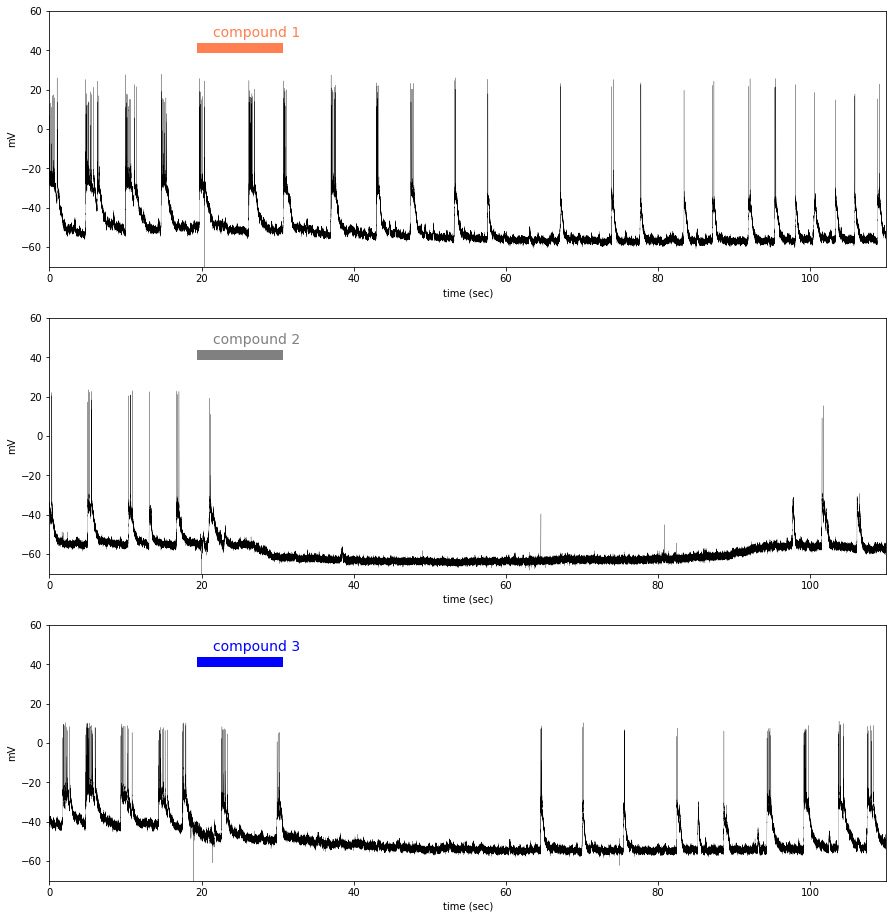

In [6]:
# Plot the traces
fig,ax= plt.subplots(3, 1, figsize=(15,16))

traces = [first_trace, second_trace, third_trace]
colors = ['coral', 'gray', 'blue']

for i, trace in enumerate(traces):
    trace.plot(ax=ax[i], legend=None,
               color='black',linewidth=0.2,
               ylim=(-70,60), xlim=(0,110),
               xlabel='time (sec)', ylabel='mV')
    
    # Indicate the duration of application for each compound
    start = 20 # application started
    end = 30 # application ended
    level = 41 # where to show an application bar (in y)
    
    ax[i].plot([start, end], [level, level], colors[i], linewidth=10) # duration of application
    ax[i].text(21.5, 47, f'compound {i+1}', color=colors[i], size=14) # label for compounds

plt.show()

# 2. Detect peaks and get firing rates

In [7]:
# Import libraries for peak detection:
# 1. find_peaks: finds all local maxima by comparison of neighboring values
# 2. medfilt: median filter
from scipy.signal import find_peaks, medfilt

In [8]:
# Example peak detection
def get_peaks(trace):
    # Prepare input as 1-D array
    val = trace['membrane potential(mV)'].values

    # Apply a median filter to reduce noise
    val = medfilt(val, kernel_size=15)
    
    # Find peaks
    peaks, _ = find_peaks(val, height=0, prominence=2) # peaks: indices of peaks
    
    return val, peaks

In [9]:
vals = {}
peaks = {}
for i in range(len(traces)):
    # Find peaks
    vals[i] = get_peaks(traces[i])[0]
    peaks[i] = get_peaks(traces[i])[1]

print(len(vals))
print(len(peaks))

3
3


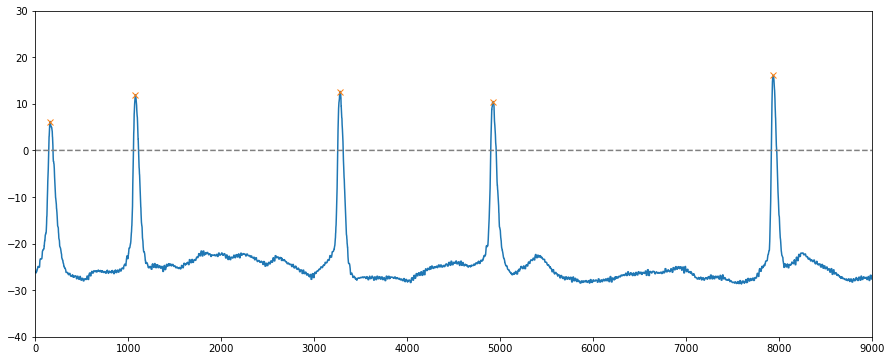

In [10]:
# Example peak detection
example_vals = vals[0]
example_peaks = peaks[0]

# Plot the peaks and threshold line on top of the trace
plt.figure(figsize=(15,6))
plt.plot(example_vals)  # trace
plt.plot(example_peaks, example_vals[example_peaks], "x")  # peaks
plt.plot(np.zeros_like(example_vals), "--", color="gray")  # height
plt.xlim(0,9000)
plt.ylim(-40,30)
plt.show()

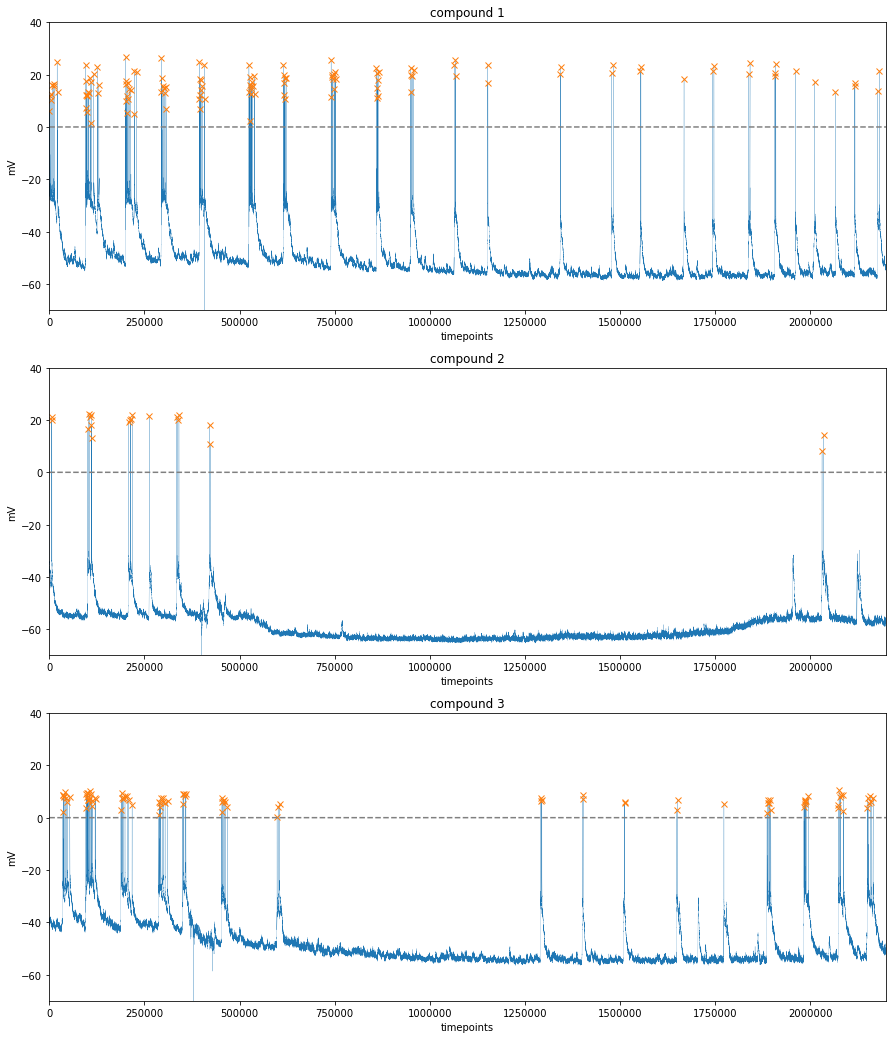

In [11]:
# Detect peaks from all three traces and plot the result
fig,ax= plt.subplots(3, 1, figsize=(15,18))
plt.subplots_adjust(hspace=.2)

for i, trace in enumerate(traces): 
    # Plot the peaks and threshold line on top of the trace
    ax[i].plot(vals[i], linewidth=0.2)  # trace
    ax[i].plot(peaks[i], vals[i][peaks[i]], "x")  # peaks
    ax[i].plot(np.zeros_like(vals[i]), "--", color="gray")  # height
    ax[i].set_ylim(-70,40)
    ax[i].set_xlim(0,2200000)
    ax[i].set_xlabel('timepoints')
    ax[i].set_ylabel('mV')
    ax[i].set_title(f'compound {i+1}')
    
plt.show()

In [12]:
# Count the peaks by every 20000 timepoints in x-axis (= 1 seconds)
bins = np.arange(0,2400000,20000)
peak_ranges = pd.DataFrame()
peak_ranges['ranges'] = pd.cut(peaks[0], bins=bins)

# Count peaks per ranges
counted = peak_ranges.value_counts(sort=False)
counted[:10]

ranges          
(0, 20000]          7
(20000, 40000]      2
(40000, 60000]      0
(60000, 80000]      0
(80000, 100000]     7
(100000, 120000]    6
(120000, 140000]    3
(140000, 160000]    0
(160000, 180000]    0
(180000, 200000]    0
dtype: int64

In [13]:
# Define the frequency
freq = 10

# Iteraterate the above process to all three traces
result = pd.DataFrame()

for i in range(len(traces)):  
    # Gather peaks per every 20000 points (= 1 second)
    peak_ranges = pd.DataFrame()
    peak_ranges['ranges'] = pd.cut(peaks[i], bins=bins)
    
    # Count peaks per ranges
    counted = peak_ranges.value_counts(sort=False)
    
    # Aggregate (sum) peak counts for every 10 seconds
    counted = pd.DataFrame(counted.values, columns=[f'compound {i+1}'])
    aggregated = counted.groupby(counted.index // freq).sum()
    
    # New index (indicate every 10 seconds)
    new_index = np.arange(0,120,freq)
    aggregated.index = new_index

    # Normalize to the baseline (first 10 seconds)
    baseline = aggregated.loc[0].values
    normalized = aggregated / baseline
    
    # Append the result to 
    result = pd.concat([result, normalized], axis=1)

result.head()

,compound 1,compound 2,compound 3
0,1.00,1.00,1.000000
10,1.12,1.00,0.566667
20,0.60,0.25,0.266667
30,0.64,0.00,0.066667
40,0.48,0.00,0.000000


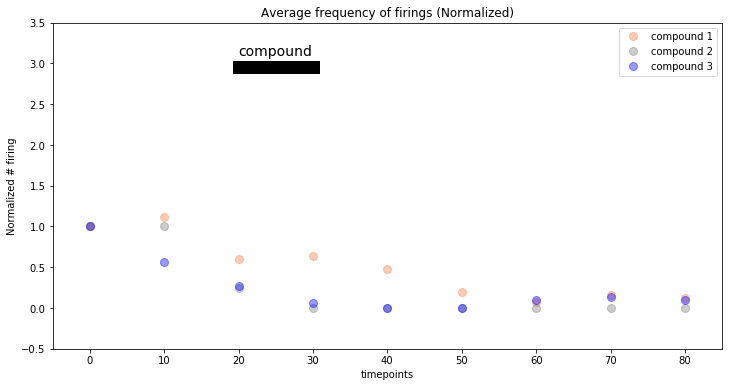

In [14]:
###### Plot the normalized frequency
result.plot(figsize=(12,6), marker='o', markersize=8, alpha=.4, linewidth=0, color=colors)
plt.xlim(-5, 85)
plt.ylim(-0.5, 3.5)
plt.title('Average frequency of firings (Normalized)')
plt.xlabel('timepoints')
plt.ylabel('Normalized # firing')
plt.plot([start, end], [2.95, 2.95], color='k', linewidth=13) # duration of application
plt.text(20, 3.1, 'compound', size=14)
plt.show()

* Note:
    
Compound 1-3 are expected to reduce neuronal excitability to different extent. The result seems to support our hypothesis, since the application of the compounds abolished the action potentials and decreased the firing frequency. In the next step, we will run statistics on a collection of data (more # of data acquired in the same condition, different date) to evaluate the significance of these compounds.

In [15]:
# Load new data (collection of all experiments)
peaks_sum =pd.read_csv("peaks.csv", delimiter=',')
peaks_sum.head()

,Compound_2_1,Compound_2_2,Compound_2_3,Compound_3_1,Compound_3_2,Compound_3_3,Compound_3_4,Compound_3_5,Compound_1_1,Compound_1_2,Compound_1_3
0,2941.0,6232.0,330.0,28007.0,35092.0,35036.0,28100.0,2387.0,165.0,27804.0,3411
1,6112.0,101037.0,2873.0,29142.0,36469.0,37427.0,29800.0,6332.0,1078.0,123817.0,4572
2,8950.0,103795.0,4370.0,30433.0,37818.0,40763.0,208000.0,7740.0,3276.0,166877.0,6875
3,11922.0,105696.0,7121.0,31368.0,39199.0,42679.0,212000.0,10025.0,4923.0,333180.0,8945
4,15356.0,110051.0,9051.0,33722.0,41873.0,56966.0,265000.0,12690.0,7936.0,338187.0,17772


In [16]:
peaks_sum_in_range = pd.DataFrame()

for i in range(len(peaks_sum.columns)):
    # Count the peaks by every 20000 timepoints in x-axis (= 1 second)
    bins = np.arange(0,2400000,20000)
    peak_ranges = pd.DataFrame()
    peak_ranges['ranges'] = pd.cut(peaks_sum.iloc[:,i], bins=bins)

    # Count peaks per ranges
    counted = peak_ranges.value_counts(sort=False)
    peaks_sum_in_range[peaks_sum.columns[i]] = counted
    
peaks_sum_in_range.head()

,Compound_2_1,Compound_2_2,Compound_2_3,Compound_3_1,Compound_3_2,Compound_3_3,Compound_3_4,Compound_3_5,Compound_1_1,Compound_1_2,Compound_1_3
ranges,,,,,,,,,,,
"(0, 20000]",6,1,10,0,0,0,0,6,7,0,6
"(20000, 40000]",7,0,9,5,4,2,2,2,2,1,1
"(40000, 60000]",6,0,7,0,4,3,0,4,0,0,2
"(60000, 80000]",7,0,6,1,0,0,0,5,0,0,4
"(80000, 100000]",6,0,4,1,3,0,0,8,4,0,1


In [62]:
# Aggregate the values by every 10 seconds
peaks_sum_in_range.reset_index(drop=True, inplace=True)
aggregated_2 = peaks_sum_in_range.groupby(peaks_sum_in_range.index // freq).sum()
aggregated_2.index = new_index
aggregated_2.head()

,Compound_2_1,Compound_2_2,Compound_2_3,Compound_3_1,Compound_3_2,Compound_3_3,Compound_3_4,Compound_3_5,Compound_1_1,Compound_1_2,Compound_1_3
0,53,6,63,12,28,19,2,54,21,3,27
10,23,8,25,11,17,9,11,49,20,4,24
20,21,2,16,1,8,4,0,50,12,4,22
30,23,0,5,0,2,0,0,31,11,5,18
40,9,0,0,0,0,0,0,24,8,7,18


In [23]:
# Normalize to the baseline (first 10 seconds)
baseline_2 = aggregated_2.loc[0].values
normalized_2 = aggregated_2 / baseline_2
normalized_2.head()

,Compound_2_1,Compound_2_2,Compound_2_3,Compound_3_1,Compound_3_2,Compound_3_3,Compound_3_4,Compound_3_5,Compound_1_1,Compound_1_2,Compound_1_3
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
10,0.433962,1.333333,0.396825,0.916667,0.607143,0.473684,5.5,0.907407,0.952381,1.333333,0.888889
20,0.396226,0.333333,0.253968,0.083333,0.285714,0.210526,0.0,0.925926,0.571429,1.333333,0.814815
30,0.433962,0.000000,0.079365,0.000000,0.071429,0.000000,0.0,0.574074,0.523810,1.666667,0.666667
40,0.169811,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.444444,0.380952,2.333333,0.666667


In [24]:
# Separate by compounds
compound_1_norm = normalized_2.iloc[:,8:11]
compound_2_norm = normalized_2.iloc[:, :3]
compound_3_norm = normalized_2.iloc[:,3:8]

In [25]:
# Get average values per timepoints for each compound
compound_1_avg = compound_1_norm.mean(axis=1)
compound_2_avg = compound_2_norm.mean(axis=1)
compound_3_avg = compound_3_norm.mean(axis=1)

# Get standard error of mean per timepoints for each compound
compound_1_sem = compound_1_norm.sem(axis=1)
compound_2_sem = compound_2_norm.sem(axis=1)
compound_3_sem = compound_3_norm.sem(axis=1)

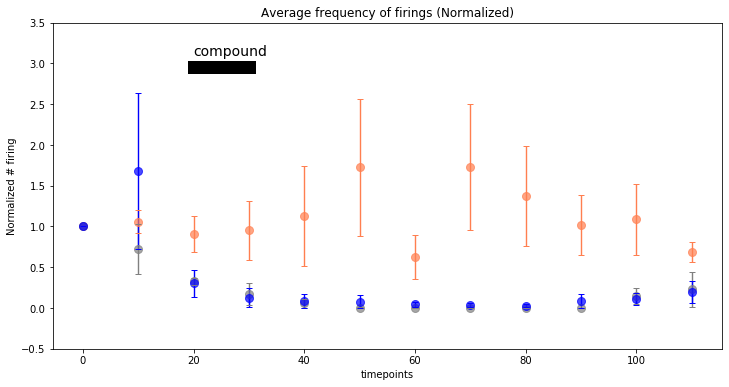

In [36]:
fig,ax= plt.subplots(figsize=(12,6))

compound_1_avg.plot(marker='o', markersize=8, alpha=.7, linewidth=0, color=colors[0])
compound_2_avg.plot(marker='o', markersize=8, alpha=.7, linewidth=0, color=colors[1])
compound_3_avg.plot(marker='o', markersize=8, alpha=.7, linewidth=0, color=colors[2])

# Error bar
ax.errorbar(new_index, compound_1_avg, yerr=compound_1_sem,
            fmt='o', ecolor=colors[0], mec='none', fillstyle='none', elinewidth=1.4, capsize=3)
ax.errorbar(new_index, compound_2_avg, yerr=compound_2_sem,
            fmt='o', ecolor=colors[1], mec='none', fillstyle='none', elinewidth=1.4, capsize=3)
ax.errorbar(new_index, compound_3_avg, yerr=compound_3_sem,
            fmt='o', ecolor=colors[2], mec='none', fillstyle='none', elinewidth=1.4, capsize=3)

plt.ylim(-0.5, 3.5)
plt.title('Average frequency of firings (Normalized)')
plt.xlabel('timepoints')
plt.ylabel('Normalized # firing')
plt.plot([start, end], [2.95, 2.95], color='k', linewidth=13) # duration of application
plt.text(20, 3.1, 'compound', size=14)

plt.show()

# 3. Statistics

In [41]:
from scipy import stats

In [59]:
# Get the values by compounds
compound_1 = peaks_sum_in_range.iloc[:,8:11]
compound_2 = peaks_sum_in_range.iloc[:, :3]
compound_3 = peaks_sum_in_range.iloc[:,3:8]

Compound_1 p-value: 0.264


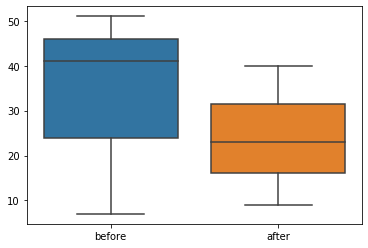

Compound_2 p-value: 0.148


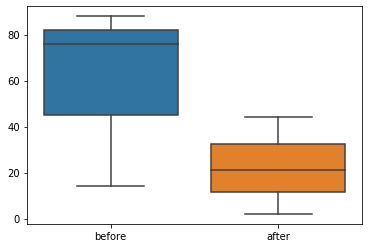

Compound_3 p-value: 0.003


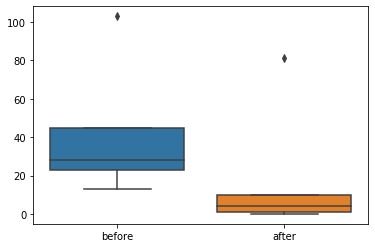

In [103]:
compounds = [compound_1, compound_2, compound_3]

for i, val in enumerate(compounds):
    # Paired t-test to compare before (0-20s) & after (20-40s) application
    before = compounds[i][:20].sum()
    after = compounds[i][20:40].sum()

    _, p_value = stats.ttest_rel(before, after)
    print(f'Compound_{i+1} p-value: {round(p_value, 3)}')

    sns.boxplot(x=['before', 'after'], y=[before, after])
    plt.show()